In [61]:
#################### Question 8 ##########################
# imports for all
import io
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import cvxpy as cp
import copy
import random
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA


In [62]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']

s = urllib.request.urlopen(url).read().decode('utf-8')
df = pd.read_csv(io.StringIO(s), header=None, names=cols)

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [63]:
X = df.drop(columns='Outcome')
y = df['Outcome']
zeros_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print("\nZero counts for medically impossible features:")
print((X[zeros_features] == 0).sum())

# median for replacing 0s
X_clean = X.copy()
for f in zeros_features:
    median_val = X_clean.loc[X_clean[f] != 0, f].median()
    X_clean.loc[X_clean[f] == 0, f] = median_val

print("\nAfter imputation (median) zero counts:")
print((X_clean[zeros_features] == 0).sum())

# 70/30 split for eval
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.30, random_state=42, stratify=y)

#feature scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



Zero counts for medically impossible features:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

After imputation (median) zero counts:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


In [64]:
clf_lin = SVC(kernel='linear', C=1.0, random_state=42)
clf_lin.fit(X_train_scaled, y_train)
y_pred_lin = clf_lin.predict(X_test_scaled)
acc_lin = accuracy_score(y_test, y_pred_lin)
cm_lin  = confusion_matrix(y_test, y_pred_lin)
report_lin = classification_report(y_test, y_pred_lin, digits=4)

print("\nLinear SVM on scaled data")
print("Accuracy:", acc_lin)
print("Confusion matrix:\n", cm_lin)
print(report_lin)

#check with unscaled data
clf_lin_unscaled = SVC(kernel='linear', C=1.0, random_state=42)
clf_lin_unscaled.fit(X_train, y_train)
acc_lin_unscaled = accuracy_score(y_test, clf_lin_unscaled.predict(X_test))
print("Accuracy (linear, unscaled):", acc_lin_unscaled)



Linear SVM on scaled data
Accuracy: 0.7272727272727273
Confusion matrix:
 [[130  20]
 [ 43  38]]
              precision    recall  f1-score   support

           0     0.7514    0.8667    0.8050       150
           1     0.6552    0.4691    0.5468        81

    accuracy                         0.7273       231
   macro avg     0.7033    0.6679    0.6759       231
weighted avg     0.7177    0.7273    0.7144       231

Accuracy (linear, unscaled): 0.7229437229437229



Kernel comparison on scaled data
        accuracy  precision    recall        f1
linear  0.727273   0.655172  0.469136  0.546763
rbf     0.740260   0.672131  0.506173  0.577465
poly    0.727273   0.714286  0.370370  0.487805


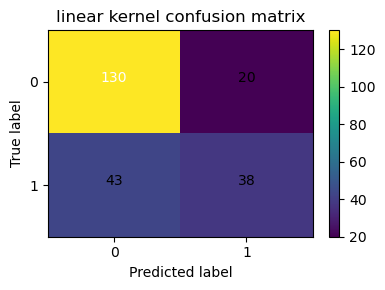

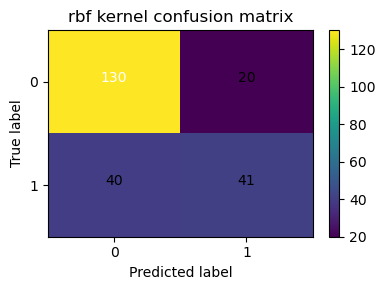

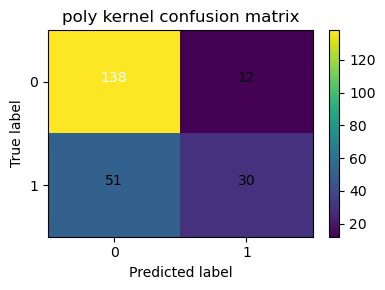

In [65]:
kernels = {
    'linear': {'kernel':'linear'},
    'rbf'   : {'kernel':'rbf', 'gamma':'scale'},
    'poly'  : {'kernel':'poly', 'degree':3, 'gamma':'scale'}
}

results = {}
for name, params in kernels.items():
    clf = SVC(**params, C=1.0, random_state=42)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'confusion': confusion_matrix(y_test, y_pred)
    }


print("\nKernel comparison on scaled data")
df_results = pd.DataFrame({k:{
    'accuracy':v['accuracy'],
    'precision':v['precision'],
    'recall':v['recall'],
    'f1':v['f1']} for k,v in results.items()}).T
print(df_results)


def plot_cm(cm, classes, title="Confusion matrix"):
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


for k,v in results.items():
    plot_cm(v['confusion'], classes=[0,1], title=f"{k} kernel confusion matrix")


In [66]:
param_grid = {'C':[0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1]}
rsvc = SVC(kernel='rbf', random_state=42)
grid = GridSearchCV(rsvc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

print("\nGridSearch best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)
best_rbf = grid.best_estimator_
y_pred_best = best_rbf.predict(X_test_scaled)
print("Test accuracy (best rbf):", accuracy_score(y_test, y_pred_best))
print("Classification report (best rbf):\n", classification_report(y_test, y_pred_best, digits=4))
#self-study note below:
# effect of very large C -> penalize slackness heavily -> near-hard margin -> low bias, high variance -> potential overfitting


Fitting 5 folds for each of 16 candidates, totalling 80 fits

GridSearch best params: {'C': 100, 'gamma': 0.001}
Best CV accuracy: 0.7857390100380754
Test accuracy (best rbf): 0.7229437229437229
Classification report (best rbf):
               precision    recall  f1-score   support

           0     0.7500    0.8600    0.8012       150
           1     0.6441    0.4691    0.5429        81

    accuracy                         0.7229       231
   macro avg     0.6970    0.6646    0.6720       231
weighted avg     0.7129    0.7229    0.7106       231




PCA(2) test accuracy (RBF): 0.7272727272727273


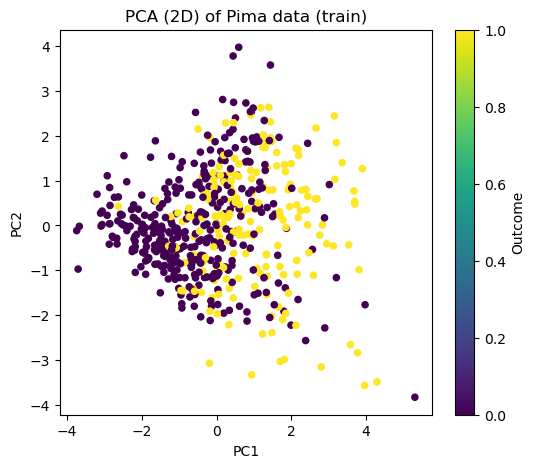

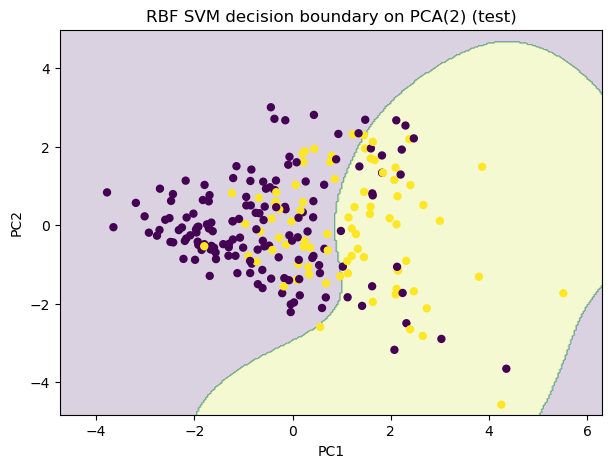

In [67]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(scaler.transform(X_clean))  # use scaled features for PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.30, random_state=42, stratify=y)
plt.figure(figsize=(6,5))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_pca, s=20, cmap='viridis')
plt.title("PCA (2D) of Pima data (train)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.colorbar(label='Outcome')

#rbf 2d
clf_pca_rbf = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
clf_pca_rbf.fit(X_train_pca, y_train_pca)

#db rgid
xx, yy = np.meshgrid(np.linspace(X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1, 300),
                     np.linspace(X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1, 300))
Z = clf_pca_rbf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test_pca, s=25)
plt.title("RBF SVM decision boundary on PCA(2) (test)")
plt.xlabel("PC1"); plt.ylabel("PC2")

acc_pca = accuracy_score(y_test_pca, clf_pca_rbf.predict(X_test_pca))
print("\nPCA(2) test accuracy (RBF):", acc_pca)


In [68]:
counts = y.value_counts()
print("\nClass counts (whole dataset):\n", counts)
print("Is imbalanced? ratio minority/majority = {:.3f}".format(counts.min()/counts.max()))
clf_standard = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
clf_standard.fit(X_train_scaled, y_train)
y_pred_std = clf_standard.predict(X_test_scaled)

#balanced svm hereeeee
clf_balanced = SVC(kernel='rbf', gamma='scale', C=1.0, class_weight='balanced', random_state=42)
clf_balanced.fit(X_train_scaled, y_train)
y_pred_bal = clf_balanced.predict(X_test_scaled)

print("\nStandard RBF recall (positive class):", recall_score(y_test, y_pred_std))
print("Balanced RBF recall (positive class):", recall_score(y_test, y_pred_bal))

print("\nFull classification report (balanced):\n", classification_report(y_test, y_pred_bal, digits=4))

#saving the table
comparison_df = df_results.copy()
comparison_df.loc['rbf']['tuned_test_accuracy'] = accuracy_score(y_test, y_pred_best)
comparison_df.loc['pca_rbf_test_accuracy'] = acc_pca
print("\nSummary comparison table:\n", comparison_df)
################# End of question 8 #############


Class counts (whole dataset):
 Outcome
0    500
1    268
Name: count, dtype: int64
Is imbalanced? ratio minority/majority = 0.536

Standard RBF recall (positive class): 0.5061728395061729
Balanced RBF recall (positive class): 0.691358024691358

Full classification report (balanced):
               precision    recall  f1-score   support

           0     0.8252    0.7867    0.8055       150
           1     0.6364    0.6914    0.6627        81

    accuracy                         0.7532       231
   macro avg     0.7308    0.7390    0.7341       231
weighted avg     0.7590    0.7532    0.7554       231


Summary comparison table:
                        accuracy  precision    recall        f1
linear                 0.727273   0.655172  0.469136  0.546763
rbf                    0.740260   0.672131  0.506173  0.577465
poly                   0.727273   0.714286  0.370370  0.487805
pca_rbf_test_accuracy  0.727273   0.727273  0.727273  0.727273


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_8412\1880449320.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  comparison_df.loc['rbf']['tuned_test_accuracy'] = accuracy_score(y_test, y_pred_best)


In [69]:
################## question 9 ####################
# load the dataset
data_path = 'Social_Network_Ads.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Please place 'Social_Network_Ads.csv' in the working directory or update data_path. Current path: {data_path}")

df = pd.read_csv(data_path)
# pick only age and estimatedsalary and purchased
# adjust if bad
if 'Age' not in df.columns or 'EstimatedSalary' not in df.columns or 'Purchased' not in df.columns:
    raise ValueError("CSV must contain columns 'Age', 'EstimatedSalary', and 'Purchased'")

X = df[['Age','EstimatedSalary']].values.astype(float)
y = df['Purchased'].values.astype(int)

# Convert labels to {-1, +1}
y_signed = np.where(y == 1, 1.0, -1.0)

In [70]:
#stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y_signed, test_size=0.3, random_state=42, stratify=y_signed)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on train
X_test_scaled = scaler.transform(X_test)
n_train = X_train_scaled.shape[0]

In [71]:
C = 1.0
w = cp.Variable(2)
b = cp.Variable()
xi = cp.Variable(n_train)

constraints = []
for i in range(n_train):
    constraints.append(y_train[i] * (w @ X_train_scaled[i] + b) >= 1 - xi[i])
constraints += [xi >= 0]

# 1/2 ||w||^2 + C * sum(xi)
objective = cp.Minimize(0.5 * cp.sum_squares(w) + C * cp.sum(xi))
prob = cp.Problem(objective, constraints)


try:
    prob.solve(solver=cp.OSQP, verbose=False)   # quiet
except Exception as e:
    print("OSQP solve failed or not available; falling back to default solver. Error:", e)
    prob.solve(verbose=True)

print("Solver status:", prob.status)
if prob.status not in ("optimal", "optimal_inaccurate"):
    raise RuntimeError("Solver did not find optimal solution. Status: " + str(prob.status))

w_opt = w.value
b_opt = b.value
xi_opt = xi.value

print("w* =", w_opt)
print("b* =", b_opt)
print("Objective value =", prob.value)

Solver status: optimal
w* = [1.68213998 1.01520715]
b* = -0.9116733206040618
Objective value = 104.96778731918661


In [72]:
#decision func
def decision_fn(X_scaled):
    return X_scaled @ w_opt + b_opt

y_scores_test = decision_fn(X_test_scaled)
y_pred_test = np.sign(y_scores_test)
acc = accuracy_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test, labels=[1.0, -1.0])  # rows true [1,-1]
print("\nTest accuracy (QP primal SVM): {:.4f}".format(acc))
print("Confusion matrix (rows true 1 then -1):\n", cm)
print("\nClassification report (treating +1 as positive):\n", classification_report(y_test, y_pred_test))



Test accuracy (QP primal SVM): 0.8333
Confusion matrix (rows true 1 then -1):
 [[28 15]
 [ 5 72]]

Classification report (treating +1 as positive):
               precision    recall  f1-score   support

        -1.0       0.83      0.94      0.88        77
         1.0       0.85      0.65      0.74        43

    accuracy                           0.83       120
   macro avg       0.84      0.79      0.81       120
weighted avg       0.84      0.83      0.83       120



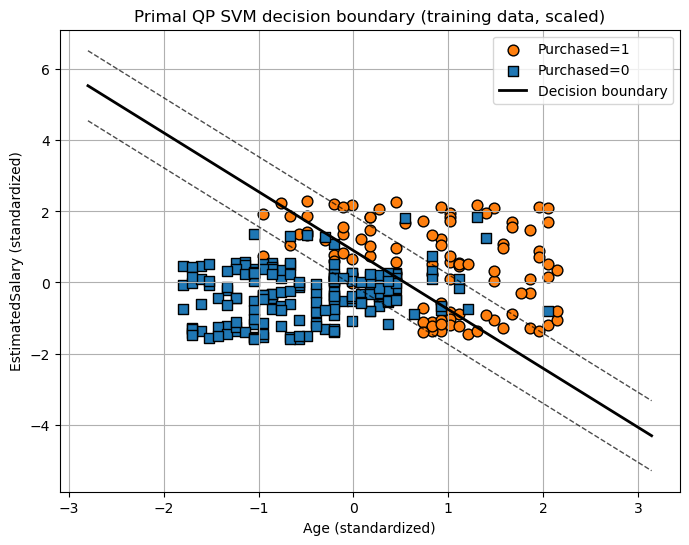

In [73]:
# overlay the line w^T x + b = 0 / color by class
plt.figure(figsize=(8,6))
# scatter for colors
mask_pos = (y_train == 1.0)
mask_neg = (y_train == -1.0)
plt.scatter(X_train_scaled[mask_pos,0], X_train_scaled[mask_pos,1], c='C1', label='Purchased=1', edgecolor='k', s=60)
plt.scatter(X_train_scaled[mask_neg,0], X_train_scaled[mask_neg,1], c='C0', label='Purchased=0', edgecolor='k', s=60, marker='s')

# db =  w0*x1 + w1*x2 + b = 0 soooo, x2 = -(w0/w1)*x1 - b/w1
xx = np.linspace(X_train_scaled[:,0].min()-1, X_train_scaled[:,0].max()+1, 200)
if abs(w_opt[1]) > 1e-8:
    yy = - (w_opt[0]/w_opt[1]) * xx - (b_opt / w_opt[1])
    plt.plot(xx, yy, 'k-', linewidth=2, label='Decision boundary')
    # margin lines: w^T x + b = +/-1
    yy_up = - (w_opt[0]/w_opt[1]) * xx - ((b_opt - 1.0) / w_opt[1])
    yy_down = - (w_opt[0]/w_opt[1]) * xx - ((b_opt + 1.0) / w_opt[1])
    plt.plot(xx, yy_up, 'k--', linewidth=1, alpha=0.7)
    plt.plot(xx, yy_down, 'k--', linewidth=1, alpha=0.7)
else:
    # vertical boundary (w[1] ~ 0)
    x_boundary = -b_opt / w_opt[0]
    plt.axvline(x=x_boundary, color='k', linewidth=2, label='Decision boundary')

plt.xlabel('Age (standardized)')
plt.ylabel('EstimatedSalary (standardized)')
plt.legend()
plt.title('Primal QP SVM decision boundary (training data, scaled)')
plt.grid(True)
plt.show()

In [74]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=C, loss='squared_hinge', dual=False, max_iter=5000, random_state=42)
clf.fit(X_train_scaled, (y_train > 0).astype(int))  # LinearSVC expects labels {0,1}
w_sklearn = clf.coef_.ravel()
b_sklearn = clf.intercept_[0]
print("\nscikit-learn LinearSVC w, b:", w_sklearn, b_sklearn)
################################# question 9 ends here ###########################################


scikit-learn LinearSVC w, b: [0.78243895 0.44980498] -0.410525447692215


In [75]:
############################ question 10 ###################################
# load
def load_jeeves(path='jeeves_tennis.csv'):
    df = pd.read_csv(path)
    df = df.copy()
    # Normalize column names
    df.columns = [c.strip() for c in df.columns]
    return df


In [76]:
# entropy and IG
def calculate_entropy(y):
    n = len(y)
    if n == 0:
        return 0.0
    counts = Counter(y)
    ent = 0.0
    for cnt in counts.values():
        p = cnt / n
        ent -= p * np.log2(p)
    return ent

def information_gain_discrete(df, feature, target_col):
    H_before = calculate_entropy(df[target_col].values)
    n = len(df)
    vals = df[feature].unique()
    cond_ent = 0.0
    for v in vals:
        subset = df[df[feature] == v]
        cond_ent += (len(subset)/n) * calculate_entropy(subset[target_col].values)
    return H_before - cond_ent

def information_gain_threshold(df, attribute, threshold, target_col):
    H_before = calculate_entropy(df[target_col].values)
    n = len(df)
    left = df[df[attribute] <= threshold]
    right = df[df[attribute] > threshold]
    H_after = 0.0
    for subset in (left, right):
        if len(subset) == 0:
            continue
        H_after += (len(subset)/n) * calculate_entropy(subset[target_col].values)
    return H_before - H_after


In [77]:
# day id
def day_id_info_gain(df, id_col='Day_ID', target_col='PlayTennis'):
    return information_gain_discrete(df, id_col, target_col)

In [78]:
#find the bset threshold
def find_best_threshold(df, attribute, target_col):
    data = df[[attribute, target_col]].sort_values(attribute).reset_index(drop=True)
    arr = data[attribute].values
    labels = data[target_col].values
    n = len(arr)
    best_gain = -1
    best_threshold = None
    for i in range(n-1):
        if labels[i] != labels[i+1]:
            t = 0.5*(arr[i] + arr[i+1])
            g = information_gain_threshold(df, attribute, t, target_col)
            if g > best_gain:
                best_gain = g
                best_threshold = t
    if best_threshold is None:
        return None, 0.0
    return best_threshold, best_gain

In [79]:
# D-tree-ID3
class TreeNode:
    def __init__(self):
        self.is_leaf = False
        self.prediction = None
        self.feature = None
        self.threshold = None    # for continuous
        self.children = {}       # for discrete: value -> child
        self.left = None         # for continuous: <= threshold
        self.right = None        # for continuous: > threshold
        self.depth = 0

class DecisionTreeID3:
    def __init__(self, max_depth=None, min_samples_split=2, verbose=False):
        self.max_depth_limit = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.verbose = verbose

    def _majority(self, y):
        return Counter(y).most_common(1)[0][0]

    def fit(self, df, feature_cols, target_col):
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.root = self._build_tree(df, feature_cols, target_col, depth=0)

    def _build_tree(self, df, features, target_col, depth):
        node = TreeNode()
        node.depth = depth
        y = df[target_col].values
        # stopping criteria
        if len(set(y)) == 1:
            node.is_leaf = True
            node.prediction = y[0]
            return node
        if len(df) < self.min_samples_split:
            node.is_leaf = True
            node.prediction = self._majority(y)
            return node
        if (self.max_depth_limit is not None) and (depth >= self.max_depth_limit):
            node.is_leaf = True
            node.prediction = self._majority(y)
            return node

        best_feature = None
        best_gain = -np.inf
        best_threshold = None
        best_is_cont = False

        for feat in features:
            if np.issubdtype(df[feat].dtype, np.number):
                thr, gain = find_best_threshold(df, feat, target_col)
                if thr is None:
                    gain = 0
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feat
                    best_threshold = thr
                    best_is_cont = True
            else:
                gain = information_gain_discrete(df, feat, target_col)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feat
                    best_threshold = None
                    best_is_cont = False

        if best_gain <= 0 or best_feature is None:
            node.is_leaf = True
            node.prediction = self._majority(y)
            return node

        node.feature = best_feature
        if best_is_cont:
            node.threshold = best_threshold
            left_df = df[df[best_feature] <= best_threshold]
            right_df = df[df[best_feature] > best_threshold]
            if len(left_df) == 0 or len(right_df) == 0:
                node.is_leaf = True
                node.prediction = self._majority(y)
                return node
            node.left = self._build_tree(left_df, features, target_col, depth+1)
            node.right = self._build_tree(right_df, features, target_col, depth+1)
        else:
            node.children = {}
            for val in df[best_feature].unique():
                subset = df[df[best_feature] == val]
                node.children[val] = self._build_tree(subset, features, target_col, depth+1)

        return node

    def predict_row(self, row):
        node = self.root
        while not node.is_leaf:
            feat = node.feature
            if node.threshold is not None:
                if row[feat] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            else:
                val = row[feat]
                if val in node.children:
                    node = node.children[val]
                else:
                    return None
        return node.prediction

    def predict(self, df):
        preds = []
        for _, row in df.iterrows():
            p = self.predict_row(row)
            if p is None:
                p = self.root.prediction
            preds.append(p)
        return np.array(preds)

    def count_nodes_and_depth(self):
        def recurse(n):
            if n is None:
                return (0, 0)
            if n.is_leaf:
                return (1, 1)
            total_nodes = 1
            total_leaves = 0
            if n.threshold is not None:
                l_nodes, l_leaves = recurse(n.left)
                r_nodes, r_leaves = recurse(n.right)
                total_nodes += l_nodes + r_nodes
                total_leaves += l_leaves + r_leaves
            else:
                for child in n.children.values():
                    c_nodes, c_leaves = recurse(child)
                    total_nodes += c_nodes
                    total_leaves += c_leaves
            return total_nodes, total_leaves
        return recurse(self.root)

    def max_depth(self):
        def recurse(n):
            if n is None:
                return 0
            if n.is_leaf:
                return 0
            depths = []
            if n.threshold is not None:
                depths.append(1 + recurse(n.left))
                depths.append(1 + recurse(n.right))
            else:
                for child in n.children.values():
                    depths.append(1 + recurse(child))
            return max(depths) if depths else 0
        return recurse(self.root)


In [80]:
# using post-pruning to reduce errors
def reduced_error_pruning(tree: DecisionTreeID3, validation_df, target_col, allow_equal=True):
    pruned = False

    def collect_internal(parent, node, branch_info, lst):
        if node is None or node.is_leaf:
            return
        # post-order traversal
        if node.threshold is not None:
            collect_internal(node, node.left, ('left', None), lst)
            collect_internal(node, node.right, ('right', None), lst)
        else:
            for val, child in node.children.items():
                collect_internal(node, child, ('child', val), lst)
        lst.append((parent, node, branch_info))

    baseline_preds = tree.predict(validation_df)
    baseline_acc = accuracy_score(validation_df[target_col].values, baseline_preds)
    nodes = []
    collect_internal(None, tree.root, (None, None), nodes)

    # bottom-up
    for parent, node, branch_info in nodes[::-1]:
        def reaches(n, row):
            cur = tree.root
            while not cur.is_leaf:
                if cur is node:
                    return True
                if cur.threshold is not None:
                    if row[cur.feature] <= cur.threshold:
                        cur = cur.left
                    else:
                        cur = cur.right
                else:
                    val = row[cur.feature]
                    if val in cur.children:
                        cur = cur.children[val]
                    else:
                        return False
            # at leaf
            return cur is node

        mask_rows = []
        for idx, row in validation_df.iterrows():
            if reaches(node, row):
                mask_rows.append(idx)
        if len(mask_rows) == 0:
            continue

        vals = validation_df.loc[mask_rows, target_col].values
        maj = Counter(vals).most_common(1)[0][0]

        backup = copy.deepcopy(node)
        node_backup = copy.deepcopy(node)
        node.is_leaf = True
        node.prediction = maj
        node.feature = None
        node.threshold = None
        node.children = {}
        node.left = None
        node.right = None
        preds = tree.predict(validation_df)
        new_acc = accuracy_score(validation_df[target_col].values, preds)

        if new_acc > baseline_acc or (allow_equal and new_acc == baseline_acc):
            baseline_acc = new_acc
            pruned = True
        else:
            node.is_leaf = node_backup.is_leaf
            node.prediction = node_backup.prediction
            node.feature = node_backup.feature
            node.threshold = node_backup.threshold
            node.children = node_backup.children
            node.left = node_backup.left
            node.right = node_backup.right

    return pruned


Information Gain for Day_ID: 0.981454
Interpretation: Day_ID is (almost) unique per row, so splitting on it creates pure leaves -> high IG but zero generalization.

Root Information Gains:
 Outlook: type=discrete, best_threshold=None, IG=0.343071
 Temperature: type=continuous, best_threshold=30.05, IG=0.023923
 Humidity: type=discrete, best_threshold=None, IG=0.053893
 Wind: type=discrete, best_threshold=None, IG=0.038228

Best discrete feature at root by IG: ('Outlook', np.float64(0.34307121026106036))

Best threshold for Temperature: t = 30.05, gain = 0.023923

Initial tree on clean data: Accuracy=0.9500, Precision(Yes)=0.9492, Recall(Yes)=0.9655
Tree size: nodes=79, leaves=42, max_depth=13

After flipping 10% labels (noise): Accuracy=0.8600, Precision(Yes)=0.9074, Recall(Yes)=0.8448
Noisy tree size: nodes=214, leaves=112, max_depth=14

Pruning iterations performed: 1
Pruned tree test accuracy: 0.9600, nodes: 56, leaves: 30, depth: 10


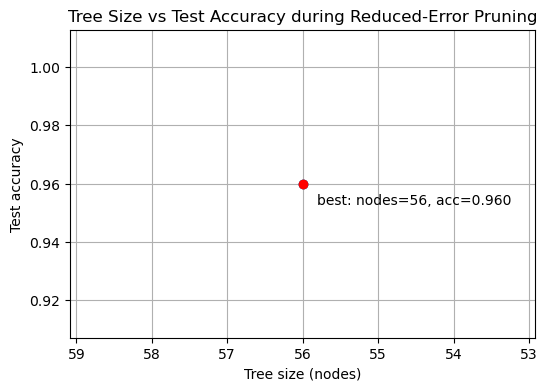

In [81]:
# util
def evaluate_model(tree, df_test, target_col):
    preds = tree.predict(df_test)
    acc = accuracy_score(df_test[target_col].values, preds)
    prec = precision_score(df_test[target_col].values, preds, pos_label='Yes', zero_division=0)
    rec = recall_score(df_test[target_col].values, preds, pos_label='Yes', zero_division=0)
    return acc, prec, rec

def flip_noise_labels(df_train, target_col, flip_fraction=0.1, seed=42):
    df = df_train.copy().reset_index(drop=True)
    n = len(df)
    rng = np.random.RandomState(seed)
    idx = rng.choice(n, size=int(np.floor(flip_fraction * n)), replace=False)
    # toggle the labels
    for i in idx:
        df.loc[i, target_col] = 'Yes' if df.loc[i, target_col] == 'No' else 'No'
    return df

def run_all(path='jeeves_tennis.csv', random_seed=42):
    df = load_jeeves(path)
    target_col = 'PlayTennis'

    # Day_ID IG
    ig_day = day_id_info_gain(df, id_col='Day_ID', target_col=target_col)
    print("Information Gain for Day_ID: {:.6f}".format(ig_day))
    print("Interpretation: Day_ID is (almost) unique per row, so splitting on it creates pure leaves -> high IG but zero generalization.\n")

    # drop Day_ID
    if 'Day_ID' in df.columns:
        df = df.drop(columns=['Day_ID'])

    features = [c for c in df.columns if c != target_col]

    # Root IGs for both
    igs = {}
    for feat in features:
        if np.issubdtype(df[feat].dtype, np.number):
            thr, gain = find_best_threshold(df, feat, target_col)
            igs[feat] = ('continuous', thr, gain)
        else:
            gain = information_gain_discrete(df, feat, target_col)
            igs[feat] = ('discrete', None, gain)

    print("Root Information Gains:")
    for k, v in igs.items():
        print(f" {k}: type={v[0]}, best_threshold={v[1]}, IG={v[2]:.6f}")

    # best discrete
    discrete_igs = {k: v[2] for k, v in igs.items() if v[0] == 'discrete'}
    if discrete_igs:
        best_discrete = max(discrete_igs.items(), key=lambda x: x[1])
        print("\nBest discrete feature at root by IG:", best_discrete)

    # threshold
    if 'Temperature' in df.columns:
        thr, gain = find_best_threshold(df, 'Temperature', target_col)
        print("\nBest threshold for Temperature: t = {}, gain = {:.6f}".format(thr, gain))

    # 80/20
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_seed, stratify=df[target_col])
    tree = DecisionTreeID3(max_depth=None, min_samples_split=1, verbose=False)
    tree.fit(train_df, features, target_col)
    acc, prec, rec = evaluate_model(tree, test_df, target_col)
    nodes, leaves = tree.count_nodes_and_depth()
    depth = tree.max_depth()
    print("\nInitial tree on clean data: Accuracy={:.4f}, Precision(Yes)={:.4f}, Recall(Yes)={:.4f}".format(acc, prec, rec))
    print("Tree size: nodes={}, leaves={}, max_depth={}".format(nodes, leaves, depth))

    # 10% for noise
    noisy_train = flip_noise_labels(train_df, target_col, flip_fraction=0.1, seed=random_seed)
    noisy_tree = DecisionTreeID3(max_depth=None, min_samples_split=1)
    noisy_tree.fit(noisy_train, features, target_col)
    acc_n, prec_n, rec_n = evaluate_model(noisy_tree, test_df, target_col)
    nodes_n, leaves_n = noisy_tree.count_nodes_and_depth()
    depth_n = noisy_tree.max_depth()
    print("\nAfter flipping 10% labels (noise): Accuracy={:.4f}, Precision(Yes)={:.4f}, Recall(Yes)={:.4f}".format(acc_n, prec_n, rec_n))
    print("Noisy tree size: nodes={}, leaves={}, max_depth={}".format(nodes_n, leaves_n, depth_n))

    train_sub, val_sub = train_test_split(train_df, test_size=0.2, random_state=random_seed, stratify=train_df[target_col])

    prunable_tree = DecisionTreeID3(max_depth=None, min_samples_split=1)
    prunable_tree.fit(train_sub, features, target_col)
    sizes = []
    accs = []
    nodes_now, _ = prunable_tree.count_nodes_and_depth()
    acc_now = accuracy_score(test_df[target_col].values, prunable_tree.predict(test_df))
    sizes.append(nodes_now)
    accs.append(acc_now)

    max_iters = 50
    for it in range(max_iters):
        pruned = reduced_error_pruning(prunable_tree, val_sub, target_col, allow_equal=True)
        nodes_now, _ = prunable_tree.count_nodes_and_depth()
        acc_now = accuracy_score(test_df[target_col].values, prunable_tree.predict(test_df))
        sizes.append(nodes_now)
        accs.append(acc_now)
        if not pruned:
            break

    print("\nPruning iterations performed:", len(sizes)-1)
    final_acc = accs[-1]
    final_nodes = sizes[-1]
    final_leaves = prunable_tree.count_nodes_and_depth()[1]
    final_depth = prunable_tree.max_depth()
    print("Pruned tree test accuracy: {:.4f}, nodes: {}, leaves: {}, depth: {}".format(final_acc, final_nodes, final_leaves, final_depth))

    # Plot Tree Size vs Test Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(sizes, accs, marker='o', linestyle='-')
    plt.xlabel("Tree size (nodes)")
    plt.ylabel("Test accuracy")
    plt.title("Tree Size vs Test Accuracy during Reduced-Error Pruning")
    plt.gca().invert_xaxis()
    plt.grid(True)
    best_idx = int(np.argmax(accs))
    plt.scatter([sizes[best_idx]], [accs[best_idx]], color='red', zorder=5)
    plt.annotate(f"best: nodes={sizes[best_idx]}, acc={accs[best_idx]:.3f}",
                 (sizes[best_idx], accs[best_idx]),
                 xytext=(10,-15), textcoords='offset points')
    plt.show()

    return {
        'initial_tree': tree,
        'noisy_tree': noisy_tree,
        'pruned_tree': prunable_tree,
        'train_df': train_df,
        'test_df': test_df,
        'features': features,
        'igs': igs,
        'day_id_ig': ig_day
    }
if __name__ == '__main__':
    import os
    path = 'jeeves_tennis.csv'
    if not os.path.exists(path):
        raise FileNotFoundError("Please place 'jeeves_tennis.csv' in the working directory.")
    results = run_all(path)

    ############################## question 10 ends here ######################################